In [6]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
import folium
import json
commune_geo_path = r'swiss-population-data/ch_municipalities.geojson'
geo_json_data = json.load(open(commune_geo_path))

# Tweeting democracy

As stated in the previous milestone, our project on the dataset of Swiss tweets aims to visualise locations of tweets made by Swiss people and also to analyse the tweets containing political content to gain insights into Twitter political activism in Switzerland.

The dataset we use is the Swisscom dataset, containing tweets mainly from 2010 to 2016. The last month available is Sep 2016. The reason we chose this dataset is because it covers a much larger timespan compared to the Spinn3r dataset, which covers less than a year, but with this dataset we can - relatively reliably - use four of the years in its timespan. However, the reliability of the dataset will be discussed later.

## Preprocessing the data

The data is in a tab-separated file, but there are several challenges:
* There are tabs and newline characters in the text field of the dataset.
* There are characters that become misrepresented as tabs.
Due to these cleanliness issues (the term "data hygiene" is sorely missed here), this step of our work is a relatively complicated one. Instead of relying on a split on newlines followed by a split on tabs for each line, we use the following process:
* We read the whole file, delete its newlines and replace tabs with a reserved string.
* We use a regular expression to match the two ids and the date/time fields (the first three fields of each line/row), and then define each line to be the area between two subsequent matched locations.
* We then count backwards from the end of the line and every time we have a match with that reserved string, we replace it with \t.

This method allows us to reconstruct most lines and recover most of the dataset, but due to the dataset being dirty with some characters being misidentified as tabs, some of our lines end up being wrong even with our regex matching. Therefore, we simply discard the lines that are wrong. We might return to this part of the work in the future, but since our method allows us to recover most of the dataset correctly (more than 99.9%), this might not be absolutely necessary.

The code for this preprocessing step is contained in https://github.com/odorgergo/ada-rag/blob/master/project/preprocessing_spark.py and https://github.com/odorgergo/ada-rag/blob/master/project/clean_dataset.py .

We then proceed to collect the columns that we need and turn them into a list of lists with the following schema:

* user id
* text
* date and time of creation
* latitude
* longitude
* language

The result is then collected from its Spark RDD and turned into a pickle file, which is then loaded and turned into a Pandas DataFrame.
As we will see later on, certain features of the dataset raise doubts about its reliability.

## Detecting the languages of tweets

The preprocessing_spark.py script that we already mentioned also performs tweet language detection after detecting lines and columns. The package we have used for this purpose is langdetect, which is a port of Google's language detection.

In [8]:
lists=pickle.load( open( "/dlabdata1/yazdania/ada_datasets/dataset.pkl", "rb" ) )
data=pd.DataFrame(lists)

In [9]:
data.columns = ['uid','date','text','latitude', 'longitude', 'language']

In [10]:
data.dtypes

uid          object
date         object
text         object
latitude     object
longitude    object
language     object
dtype: object

Latitude and longitude are nullable.

In [11]:
data.head()

,uid,date,text,latitude,longitude,language
0,17341045,2010-02-23 05:55:51,Guuuuten Morgen! :-),\N,\N,nl
1,7198282,2010-02-23 06:22:40,Still the best coffee in town — at La Stanza h...,\N,\N,en
2,14657884,2010-02-23 07:34:25,It has been a week or so.. and today I just co...,\N,\N,en
3,14703863,2010-02-23 07:51:47,Getting ready.. http://twitpic.com/14v8gz,\N,\N,en
4,14393717,2010-02-23 08:02:57,Un peu de réconfort liquide en take away après...,\N,\N,fr


In [12]:
data['year'] = data['date'].map(lambda x: x.split(' ')[0].split('-')[0])
data['month'] = data['date'].map(lambda x: x.split(' ')[0].split('-')[1])
data['day'] = data['date'].map(lambda x: x.split(' ')[0].split('-')[2])
data['latitude'] = pd.to_numeric(data['latitude'], errors='coerce')
data['longitude'] = pd.to_numeric(data['longitude'], errors='coerce')

In [13]:
usergroups=data[["uid","date"]].groupby("uid")
usercounts=usergroups.date.count()

## Basic Stats

Here, we count the tweets of each user, and then count the number of users having the same number of tweets and then draw a scatterplot of the number of users having a tweet count against the tweet count itself, on log-log axes. We can see that the relationship between the number of users with a certain tweet count and that count itself seems to obey a power law.

In [14]:
un,count=np.unique(usercounts.values, return_counts=True)

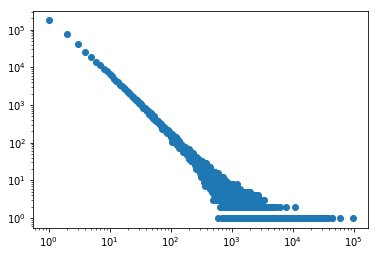

In [15]:
plt.scatter(un,count)
plt.xscale("log",nonposx="clip")
plt.yscale("log",nonposy="clip")

By defining as active a user who has over 100 tweets overall, we arrive at the following statistics:

In [16]:
print("Number active users", usercounts.loc[usercounts>100].shape[0])
print("Number of total users", usercounts.shape[0])

Number active users 21436
Number of total users 483250


In [17]:
data.dropna(inplace=True)

In [18]:
data.head()

,uid,date,text,latitude,longitude,language,year,month,day
546,6257282,2010-03-09 18:09:51,"The new apartment is nice, but there is no Wif...",47.5367,7.57849,en,2010,03,09
603,15602037,2010-03-10 22:44:24,Is that wet yet solid stuff on my screen suppo...,47.3791,8.50021,en,2010,03,10
605,625553,2010-03-11 05:59:25,I'm at DCTI - David Dufour in Geneva http://go...,46.1996,6.13011,en,2010,03,11
606,17341045,2010-03-11 06:18:47,God morgon! :-),46.9214,7.38855,cy,2010,03,11
612,634553,2010-03-11 07:03:10,"At this very minute, the sun is pink.",46.1938,6.15415,en,2010,03,11


In [19]:
data.shape

(17956480, 9)

In [20]:
data.dtypes

uid           object
date          object
text          object
latitude     float64
longitude    float64
language      object
year          object
month         object
day           object
dtype: object

The following are histograms of tweet counts per month, per year. As you can see, the number of tweets that we have from 2010 is very low, and it starts increasing steadily until it finally reaches a relatively considerable number (~100K) per month. However, one of the important issues with our dataset is the fact that the tweet counts are quite uneven across different months and there is even a month completely missing (August 2013). Despite that, we hope to be able to draw useful conclusions, especially in 2014, 2015 and 2016 (up to September).

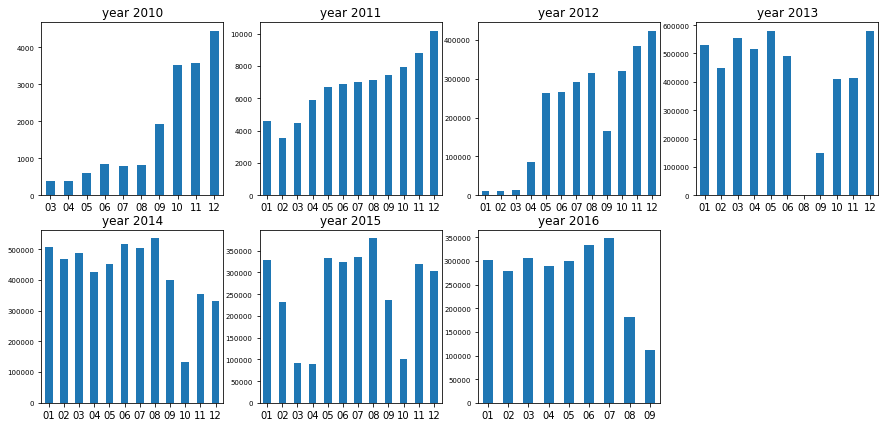

In [21]:
plt.figure(figsize=(15,7))
years=list(range(2010,2017))
for i in range(len(years)):
    plt.subplot(2,4,i+1)
    data[data['year']==str(years[i])]['month'].value_counts().sort_index().plot(kind='bar', rot=0, title = 'year '+ str(years[i]));
    plt.yticks(fontsize=7)


## Maps

The following is not the final version of our maps; these are two types of maps that we could use in the next milestone, although a choropleth seems to be the better choice. We have a map of Switzerland down to municipality (commune) level, and we use the coordinates provided in the dataset along with the package 'shapely' which, having a geojson file and a set of points, allows us to find the polygons in that geojson that each of those points fall into. This way, we can achieve two goals:
* Easy removal of tweets from outside the Swiss borders: any point not falling into any of the polygons is coming from outside Switzerland, and will be discarded for our on-map visualisation task (although they, along with the tweets lacking geolocation data, will still be kept for our text analysis task which will be explained later).
* Finding the number of tweets coming from each municipality, which along with population densities of each municipality, allow us to gain insights into the "popularity" of Twitter in each municipality of Switzerland. One challenge in this task is the potential inaccuracy of the geolocation, and more importantly, the fact that many municipalities will have very few tweets coming from them.

In [22]:
locationlist = data[data['year']=='2016'][['latitude', 'longitude']].values.tolist()
marker_map = folium.Map([46.8,8], zoom_start=8)
folium.GeoJson(geo_json_data).add_to(marker_map)
for point in range(0, 100):
    folium.Marker(locationlist[point], popup=data[data['year'] == '2016'].reset_index()['language'][point]).add_to(marker_map)
marker_map

In [23]:
from shapely.geometry import shape,Point
def get_city_name(long,lat):
    point = Point(long,lat)
    for feature in geo_json_data['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['GMDNAME']

In [24]:
sep_6th_2016 = data[(data['year']=='2016')&(data['month']=='09')&(data['day']=='06')]
loc_list = sep_6th_2016[['latitude', 'longitude']].values.tolist()
sep_6th_2016['municipality'] = [get_city_name(x[1],x[0]) for x in loc_list]
sep_6th_2016['count'] = np.ones(sep_6th_2016.shape[0])
sep_6th_2016_counts = sep_6th_2016.groupby('municipality').sum().reset_index()

/home/odor/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/odor/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The following is a choropleth map of tweets for one day, September 6th 2016. For the next milestone, we will have more complete maps for months/years.

In [25]:
tweet_map = folium.Map([46.8,8], zoom_start=8, tiles='cartodbpositron')
tweet_map.choropleth(geo_data=geo_json_data, data=sep_6th_2016_counts,
             columns=['municipality', 'count'],
             key_on='feature.properties.GMDNAME',
             fill_color='PuRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='number of tweets in 6th of september 2016')
tweet_map

## Distribution of languages - a biased dataset

This is where the dataset starts looking unreliable.
The following shows the distributions of languages in the dataset. As you can see, there are almost 6 million French tweets, followed by over 3.5 million English tweets, but surprisingly, German tweets are in the 4th place after Italian. In a country with a German-speaking majority, this extreme unbalance can hint at two possibilities:

* Swiss-Germans have been slow to adopt Twitter, prefer other types of social media, or simply use (a lot) more English.
* The dataset is unbalanced for unknown reasons, and therefore this rather extreme unbalance has to be taken into account for any kind of analysis, because it appears that most tweets in the dataset are coming from the French-speaking parts.

I believe the reader already knows which of the two possibilities above we are more inclined to believe. Our idea for checking this lack of balance is to check the other dataset (Spinn3r) and to compare them in a timeframe existing in both datasets. To guard against this imbalance, we will always have to be careful in the conclusions we draw from the data.

In [26]:
counts=data.groupby("language").date.count().sort_values(ascending=False)
counts=counts.reset_index()
counts.columns=["language","count"]

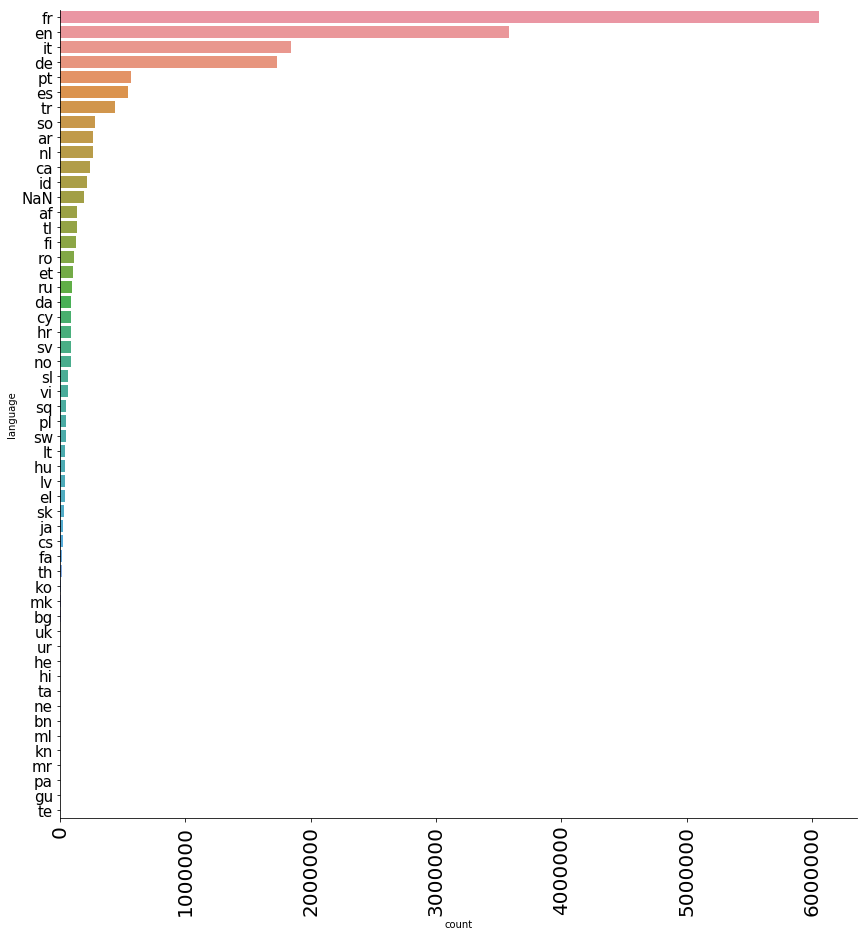

In [27]:
ax = sns.factorplot(size=12,kind = 'bar', y="language", x="count", data=counts, orient='h')
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=15)
plt.show(ax)

If we only look at 2016, we can see that the imbalance seems to be less pronounced, but still considerable.

In [28]:
counts16=data[data['year']=='2016'].groupby("language").date.count().sort_values(ascending=False)
counts16=counts16.reset_index()
counts16.columns=["language","count"]

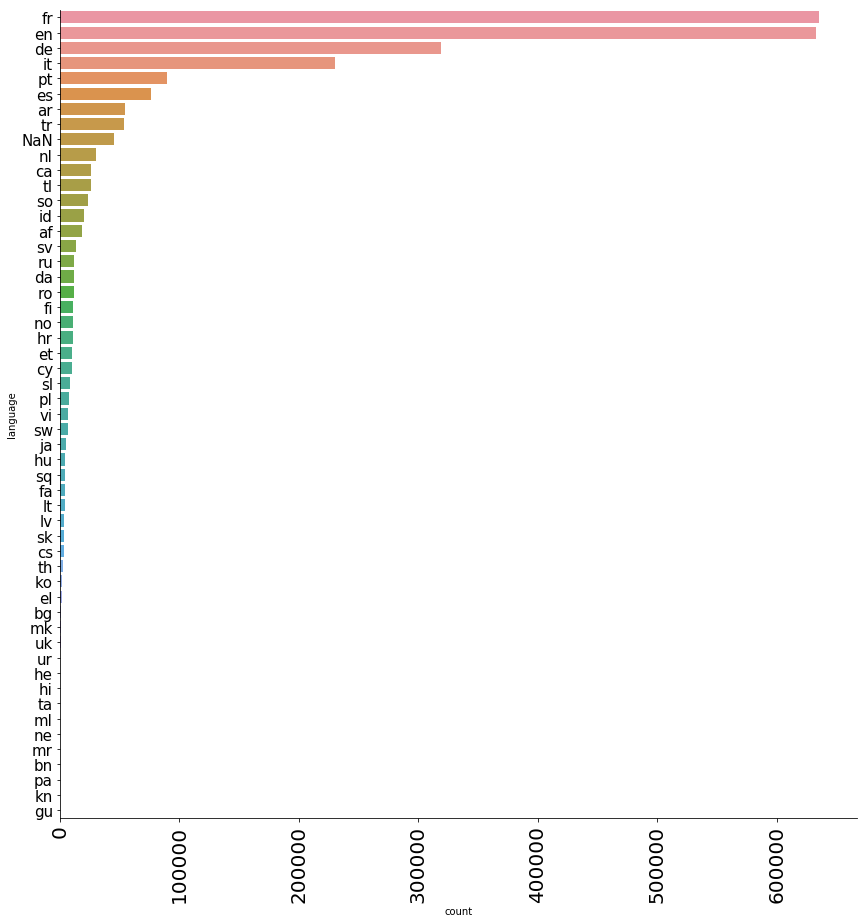

In [29]:
ax = sns.factorplot(size=12,kind = 'bar', y="language", x="count", data=counts16, orient='h')
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=15)
plt.show(ax)

## Preliminary exploratory analysis of political acitvity

Our approach to finding political activity will be using a form of bootstrapping: we will start with a limited set of political words and their French and German translations, and we will find tweets that have used them. This initial set must preferably contain words that are unambiguously political, so that the tweets we find can be relied upon for the next step.

The next step is to construct a language model for the entirety of the dataset, and also a language model for the set of political tweets we have found. Then, words that are much more likely in the political tweets than in the whole dataset are likely to be politically charged; we will then add them to our set of political words and then repeat this process until convergence (or another stopping criterion). Then, we can analyse this set of political tweets, both in terms of the political words and also through time; we can check if there are spikes in political activity and whether or not they seem to consistently co-occur with significant political events (such as referendums).

The following features a preliminary exploration of the data, in which we find the number of users who have tweeted about the FDP (Free Democratic Party).

In [30]:
FDP=data.text.map(lambda x: x.find(" FDP ")>0)
print(data.loc[FDP,"text"].shape[0])
data.loc[FDP].head()

2660


,uid,date,text,latitude,longitude,language,year,month,day
4720,12960732,2010-05-27 08:13:48,@phogenkamp der FDP auch schon beigetreten?,47.3774,8.53676,de,2010,05,27
11625,120433,2010-08-27 20:33:29,"@Augenarbeiter blutleer, emotionslos und masku...",46.9415,7.45821,no,2010,08,27
18230,12960732,2010-10-29 15:57:03,Woher die FDP wohl das Geld für die Plakate ni...,46.5000,7.28948,de,2010,10,29
40531,13412102,2011-04-05 08:40:16,@MaurusZeier denke der FDP sind viele Richtung...,47.3774,8.53676,de,2011,04,05
47375,15189855,2011-05-08 12:19:12,Dokument der Verzweiflung: FDP sucht Wahlerfol...,47.2054,7.00224,de,2011,05,08


Number of such tweets by each of the users appearing in the aforementioned set.

In [31]:
data.loc[FDP].groupby("uid").date.count().sort_values(ascending=False).head()

uid
115089595    71
766016468    41
738347538    40
926755556    32
637214796    32
Name: date, dtype: int64

This particular account is a news account belonging to "News Zürich & Region".

In [32]:
data.loc[data.uid=="115089595"].head()

,uid,date,text,latitude,longitude,language,year,month,day
947852,115089595,2012-07-20 23:26:17,Rückeroberung: [nzz.ch] Wädenswil kauft die be...,47.3774,8.53676,de,2012,07,20
947986,115089595,2012-07-20 23:43:01,#ZweiMänner vom Land: [nzz.ch] Ex-Parteisekret...,47.3774,8.53676,de,2012,07,20
948153,115089595,2012-07-21 00:07:33,Der Flughafen Zürich spaltet #Bund und Kanton:...,47.3774,8.53676,de,2012,07,21
948243,115089595,2012-07-21 00:24:02,"Ich muss schauen, dass ich wenigstens etwas tr...",47.3774,8.53676,de,2012,07,21
948332,115089595,2012-07-21 00:40:18,BVK-Versicherte stimmen online über Stiftungsr...,47.3774,8.53676,de,2012,07,21


Now let's look at a controversial referendum that took place on 2016.06.05, regarding a universal basic income. Tweets about this matter seem to increase near the time of the referendum, although the low total number of tweets containing this phrase limits our ability to draw conclusions.

In [35]:
revenudebase=data.text.map(lambda x: x.find("revenu de base")>0)
print(data.loc[revenudebase].shape[0])
data.loc[revenudebase].head()

33


,uid,date,text,latitude,longitude,language,year,month,day
486419,142250462,2012-05-30 21:37:47,@magaliphilip #EnLD pour quand un débat sur le...,46.1851,6.12163,fr,2012,05,30
5093385,98840585,2013-05-21 09:14:26,Présentation au cours de français du projet «r...,47.0408,8.31721,fr,2013,05,21
5189193,338424822,2013-05-26 13:46:23,Les Suisses voteront sur le principe d'un reve...,46.2048,6.14319,fr,2013,05,26
5794994,39415768,2013-09-20 11:25:36,"Pourquoi vous êtes, sans le savoir, favorable ...",46.2465,6.13303,fr,2013,09,20
6416574,47706812,2013-11-07 13:37:44,@manudwarf @Delphine_D le revenu de base est e...,47.8658,7.22276,fr,2013,11,07


In [34]:
revenudebase=data.text.map(lambda x: x.find("grundeinkommen")>0)
print(data.loc[revenudebase].shape[0])
data.loc[revenudebase].head()

67


,uid,date,text,latitude,longitude,language,year,month,day
171104,15967348,2012-04-21 12:45:06,@schmidi_dog erhält eben bedingungslos ein #gr...,47.3774,8.53676,de,2012,04,21
194526,14302013,2012-04-23 20:22:31,"""grundeinkommen ist ja ok, aber doch nicht für...",47.3774,8.53676,de,2012,04,23
8005979,8614392,2014-02-11 00:12:12,Ueber das Bedingungslose .@grundeinkommen ber...,47.5601,7.61289,de,2014,02,11
9738360,238128600,2014-06-05 08:11:36,#ForumG21 das hauptproblem der zukunft ist #ar...,46.5287,6.65208,de,2014,06,05
11154466,25268947,2014-08-27 15:55:52,Bundesrat hat Angst vor fehlenden Arbeitsanrei...,47.4746,7.58434,de,2014,08,27


## The next steps

- A detailed visualization of the languages, population densities vs twitter activity, as explained in the "Maps" section.
- Doing a better job with detecting political tweets: Bootstrapping
- Looking for spikes in the political tweets
- Finding out whether certain parties are over-represented in our dataset (which might very well be the case given the imbalance in language, knowing that left-wing and centrist parties are more popular in the French-speaking part, while more right-leaning parties appear to be popular in the German-speaking parts (this is according to the latest election results, not this Twitter dataset).
- Analysing the tweets of certain newspapers and/or politicians to see which words seem to be more prevalent in their speech (although it might not be quite proper to call tweets "speech").